# Introduction

## First algorithm
This tutorial is made to introduce you to the Gaggle framework. Pytorch experience is recommended but not necessary. In this tutorial, we will go over using the GASupervisor to solve problems! In particular, we'll evolve a population of Neural Networks to solve the MNIST classification problem (https://en.wikipedia.org/wiki/MNIST_database).
GPU acceleration is recommended but not necessary.

Quick Note: None of the training configurations presented in this tutorial are optimal or even remotely good. These are just chosen to be fast and easy to run even on machines with lower-end hardware. This tutorial's goal is to showcase how the code works, not solving any of the particular problems mentioned.

Batching is not necessary, will store the entire data on device: cuda
Genome size: 1.367e+04 params

--------------------------------------------------------------------------------
crossover               : uniform
elitism                 : 0.1000
eval_every_generation   : 50
ga_name                 : simple
generations             : 20
k_point                 : 1
mutate_protected        : False
mutation                : normal
mutation_chance         : 0.0100
mutation_std            : 0.0500
num_parents             : 10
parent_survival_rate    : 0.5000
population_size         : 10
save_best_every         : None
save_every_epoch        : False
selection               : weighted
selection_pressure      : 0.5000
tournament_size         : 3
uniform_mutation_max_val: 1.0000
uniform_mutation_min_val: -1.0000
use_freshness           : True
--------------------------------------------------------------------------------


----------------------------------------------------------------------

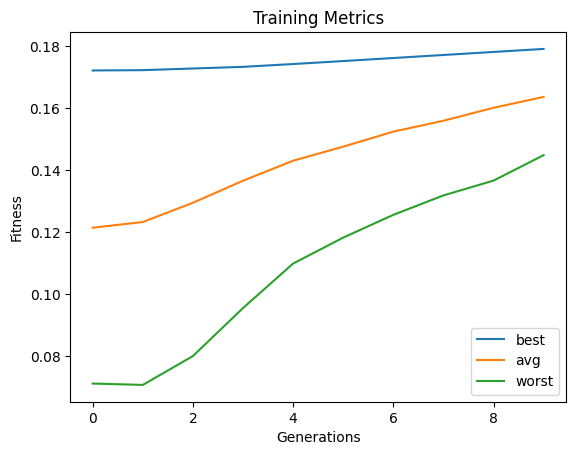

In [1]:
%load_ext autoreload
%autoreload 2
%pwd

# First we import the required dependencies
from gaggle import GASupervisor

# We set the device on which to run the code, if gpu acceleration is available (recommended), this should be set as
device="cuda"
# otherwise, we use the cpus by default
# device="cpu"

# we now setup the supervisor with the following parameters
# we want to solve MNIST
problem_name = "MNIST"

# we want to evolve a neural network to solve it
individual_name = "nn"

# there are many neural network architectures to choose from, but for now we'll use the snet architecture
model_name = "snet_mnist"

# we can now initialize the Supervisor with the chosen parameters. We choose a population size of 10 and match the number of parents. We also choose a small number of generations.
supervisor = GASupervisor(population_size=10, num_parents=10, generations=20, problem_name=problem_name, individual_name=individual_name, model_name=model_name, device=device, display_train_metrics=True, display_test_metrics=False)

# All that is left is to run it!
supervisor.run()


## Choosing your operators

As you may have noticed in the previous code snippet, nowhere did we mention any of the typical GA operators. That is because the GASupervisor used the default operators when there isn't any specified.
If we want to use different operators than the ones used by default, all we have to do is specify them and any of their associated arguments when initializing the GASupervisor.

By default, we use uniform crossover, let's change that to k_points with 3 points.

In [2]:
crossover = "k_point"
k_point = 3


We also now want to use simple tournament selection instead of the default weighted (roulette wheel) selection.

In [3]:
selection = "simple_tournament"

Finally, let's now use a different mutation. By default we use the normal distribution mutation. Let's switch it to a uniform distribution mutation.
It uses two additional parameters: uniform_mutation_max_val and uniform_mutation_min_val which sets the sampling range for the mutation. By default they are 1 and -1.

In [4]:
mutation = "uniform"
uniform_mutation_max_val = 0.5
uniform_mutation_min_val = -0.5

We can now train our model with these new parameters.

In [5]:
supervisor = GASupervisor(crossover=crossover, selection=selection, mutation=mutation, uniform_mutation_max_val=uniform_mutation_max_val, uniform_mutation_min_val=uniform_mutation_min_val, k_point=k_point,population_size=10, num_parents=10, generations=2, problem_name=problem_name, individual_name=individual_name, model_name=model_name, device=device, display_train_metrics=False, display_test_metrics=False)

supervisor.run()

Batching is not necessary, will store the entire data on device: cuda
Genome size: 1.367e+04 params

--------------------------------------------------------------------------------
crossover               : k_point
elitism                 : 0.1000
eval_every_generation   : 50
ga_name                 : simple
generations             : 2
k_point                 : 3
mutate_protected        : False
mutation                : uniform
mutation_chance         : 0.0100
mutation_std            : 0.0500
num_parents             : 10
parent_survival_rate    : 0.5000
population_size         : 10
save_best_every         : None
save_every_epoch        : False
selection               : simple_tournament
selection_pressure      : 0.5000
tournament_size         : 3
uniform_mutation_max_val: 0.5000
uniform_mutation_min_val: -0.5000
use_freshness           : True
--------------------------------------------------------------------------------


-------------------------------------------------------------

## Making your own problem to solve

Now that we've seen how to solve pre-built problems, let's tackle how to introduce custom problems to our framework using the supervisor.

For this, we'll use the well-known benchmark Rastrigin Problem, where the goal is for the genome of individuals to minimize the Rastrigin function specified below.

To do this, we'll use one of our default individuals: the PytorchIndividual. It is a simple individual whose stores its genome as a flattened pytorch tensor and returns them when it is called.


In [6]:
import torch


def fitness_function(individual):
    # we get the genome as a flattened pytorch tensor
    genome = individual()
    # we get the size of the genome of the individual (in this case the length of the tensor)
    genome_size = individual.get_genome_size()
    rastrigin = - (10 * genome_size + torch.sum(genome ** 2 - 10 * torch.cos(2 * torch.pi * genome)))
    return rastrigin.cpu().item()

# now that we've defined our custom fitness function, we need to specify that we want to use the pytorch individual
individual_name = "pytorch"

# the pytorch individual uses an additional parameter, the size of the individual's genome to create.
individual_size = 100

# we have to set the problem_name to custom as we are using our own custom fitness function
problem_name = "custom"

# since rastrigin tries to maximize a negative number, we use our roulette wheel selection which has min offset by default to allow for proper selection even with negative valued fitnesses
selection = "weighted"

# we can now create a new supervisor to solve this problem
supervisor = GASupervisor(individual_size=individual_size, crossover=crossover, selection=selection, mutation=mutation, uniform_mutation_max_val=uniform_mutation_max_val, uniform_mutation_min_val=uniform_mutation_min_val, k_point=k_point,population_size=10, num_parents=10, generations=2, problem_name=problem_name, individual_name=individual_name, device=device, display_train_metrics=False, display_test_metrics=False)

# We now set the fitness function in the supervisor
supervisor.set_custom_fitness(fitness_function=fitness_function)

# We can now run it
supervisor.run()

Genome size: 1.000e+02 params

--------------------------------------------------------------------------------
crossover               : k_point
elitism                 : 0.1000
eval_every_generation   : 50
ga_name                 : simple
generations             : 2
k_point                 : 3
mutate_protected        : False
mutation                : uniform
mutation_chance         : 0.0100
mutation_std            : 0.0500
num_parents             : 10
parent_survival_rate    : 0.5000
population_size         : 10
save_best_every         : None
save_every_epoch        : False
selection               : simple_tournament
selection_pressure      : 0.5000
tournament_size         : 3
uniform_mutation_max_val: 0.5000
uniform_mutation_min_val: -0.5000
use_freshness           : True
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
avg        (len=1): [-1042.8187622070313]
best    